In [4]:
import numpy as np
import librosa
import soundfile as sd
import os
import sklearn
from sklearn.mixture import GaussianMixture
import joblib
import pandas as pd
import os
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extrait les MFCCs et supprime le premier coefficient (énergie)."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc[1:, :]  # Supprime le premier coefficient (énergie)

In [69]:
def remove_silence(y, sr, output_path=None, top_db=20, frame_length=2048, hop_length=512):
    """
    Supprime les silences d'un signal audio.
    
    Paramètres:
        y: signal audio (numpy array)
        sr: taux d'échantillonnage
        output_path: (optionnel) chemin pour sauvegarder le résultat
        top_db: seuil pour la détection du silence
    """
    # Détecter les segments non silencieux
    non_silent_indices = librosa.effects.split(y, top_db=top_db, 
                                             frame_length=frame_length, 
                                             hop_length=hop_length)
    
    # Concaténer les segments non silencieux
    y_non_silent = np.concatenate([y[start:end] for start, end in non_silent_indices])
    
    # Sauvegarder le résultat si un chemin est fourni
    if output_path is not None:
        sf.write(output_path, y_non_silent, sr)
        print(f"Audio sans silence sauvegardé sous : {output_path}")
    
    return y_non_silent

In [71]:
def process_audio_files(input_dir, output_dir, output_mfcc_dir, target_sr=16000):
    """
    Parcourt les fichiers audio dans le répertoire d'entrée,
    supprime les silences, extrait les MFCCs et sauvegarde les résultats.
    """
    for root, _, files in os.walk(input_dir):
        for file in files:
            if not file.endswith(".wav"):
                continue

            # Définir les chemins complets
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(input_path, input_dir)
            cleaned_audio_path = os.path.join(output_dir, relative_path)
            mfcc_output_path = os.path.join(output_mfcc_dir, relative_path.replace(".wav", ".mfcc"))

            # Créer les répertoires de sortie si nécessaire
            os.makedirs(os.path.dirname(cleaned_audio_path), exist_ok=True)
            os.makedirs(os.path.dirname(mfcc_output_path), exist_ok=True)

            # Charger le fichier audio
            y, sr = librosa.load(input_path, sr=target_sr)

            # Supprimer les silences
            y_clean = remove_silence(y, sr=sr, top_db=30)

            # Vérifier que le signal n'est pas vide après suppression du silence
            if len(y_clean) == 0:
                print(f"[IGNORÉ] {input_path} : signal vide après suppression des silences.")
                continue

            # Sauvegarder uniquement les fichiers audio nettoyés dans OUTPUT_DIR
            sd.write(cleaned_audio_path, y_clean, sr)
            print(f"[AUDIO OK] Sauvegardé : {cleaned_audio_path}")

            # Extraire les MFCCs et les sauvegarder dans OUTPUT_MFCC_DIR
            mfcc = extract_mfcc(y_clean, sr)
            np.savetxt(mfcc_output_path, mfcc, delimiter=",")
            print(f"[MFCC OK] Sauvegardé : {mfcc_output_path}")

In [73]:
INPUT_DIR = "Reconnaissance_du_locuteur"
OUTPUT_DIR = "Reconnaissance_du_locuteur_clean"
OUTPUT_MFCC_DIR = "MFCC"
process_audio_files(INPUT_DIR, OUTPUT_DIR, OUTPUT_MFCC_DIR)

[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\10s\Seg1.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\10s\Seg1.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\10s\Seg2.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\10s\Seg2.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\10s\Seg3.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\10s\Seg3.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\10s\Seg4.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\10s\Seg4.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\10s\Seg5.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\10s\Seg5.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\15s\Seg1.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\15s\Seg1.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\15s\Seg2.wav
[MFCC OK] Sauvegardé : MFCC\F1\Test\15s\Seg2.mfcc
[AUDIO OK] Sauvegardé : Reconnaissance_du_locuteur_clean\F1\Test\15s\Seg3.wav
[MFCC OK] Sauvegardé : MFC

In [84]:
def load_mfcc_for_speaker(train_mfcc_path):
    """Load the MFCC file for a speaker from the 'Train' folder."""
    for file in os.listdir(train_mfcc_path):
        if file.endswith(".mfcc"):  # Ensure correct format
            file_path = os.path.join(train_mfcc_path, file)
            return np.loadtxt(file_path, delimiter=",").T  # Load & transpose MFCC

    return None  # Return None if no valid MFCC file is found

In [86]:
def train_gmm_for_speakers(mfcc_dir,output_dir, n_components_list=[8, 16, 32, 64, 128, 256]):
    """Train GMM models for each speaker using only the 'Train' folder MFCC."""
    
    speakers = os.listdir(mfcc_dir)  # Each folder is a speaker

    for speaker in speakers:
        train_path = os.path.join(mfcc_dir, speaker, "Train")  # Only use Train folder
        model_dir = os.path.join(output_dir, speaker)  # Save models in MFCC/{speaker}/Model/
        os.makedirs(model_dir, exist_ok=True)  # Create model directory if needed
        
        mfcc_features = load_mfcc_for_speaker(train_path)
        
        if mfcc_features is None:
            print(f"Skipping {speaker}, no MFCC data found in Train folder.")
            continue
        
        for n_components in n_components_list:
            gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
            gmm.fit(mfcc_features)  # Train the model
            
            model_filename = os.path.join(model_dir, f"{speaker}_{n_components}.gmm")
            joblib.dump(gmm, model_filename)  # Save model
            print(f"Saved GMM model for {speaker} with {n_components} components at {model_filename}") 

In [88]:
mfcc_dir = r"MFCC"
output_dir = r"GMM"
train_gmm_for_speakers(mfcc_dir,output_dir)


Saved GMM model for F1 with 8 components at GMM\F1\F1_8.gmm
Saved GMM model for F1 with 16 components at GMM\F1\F1_16.gmm
Saved GMM model for F1 with 32 components at GMM\F1\F1_32.gmm
Saved GMM model for F1 with 64 components at GMM\F1\F1_64.gmm
Saved GMM model for F1 with 128 components at GMM\F1\F1_128.gmm
Saved GMM model for F1 with 256 components at GMM\F1\F1_256.gmm
Saved GMM model for F10 with 8 components at GMM\F10\F10_8.gmm


KeyboardInterrupt: 

In [90]:


def load_test_mfccs(base_dir, duration):
    """Load all test MFCCs for a specific duration (5s, 10s, or 15s)"""
    test_mfccs = {}
    
    for speaker in os.listdir(base_dir):
        speaker_path = os.path.join(base_dir, speaker)
        if not os.path.isdir(speaker_path):
            continue
        
        test_dir = os.path.join(speaker_path, "test", duration)  # <-- corrigé "Test" → "test"
        if not os.path.exists(test_dir):
            continue
        
        segments = []
        for seg in range(1, 6):  # segments 1 to 5
            mfcc_file = os.path.join(test_dir, f"seg{seg}.mfcc")  # <-- corrigé f"{speaker}_{seg}.mfcc"
            if os.path.exists(mfcc_file):
                try:
                    mfcc = np.loadtxt(mfcc_file, delimiter=",").T
                    segments.append(mfcc)
                except Exception as e:
                    print(f"Erreur lors du chargement de {mfcc_file} : {e}")
        if segments:
            test_mfccs[speaker] = segments
            
    return test_mfccs

def get_gender(speaker):
    """Return 'F' for female speakers, 'H' for male speakers"""
    return 'F' if speaker.startswith('F') else 'H'

def test_models(base_dir, models_dir, duration, output_excel_path):
    """Test all models against test segments of specific duration"""
    test_mfccs = load_test_mfccs(base_dir, duration)
    
    columns = ['Locuteur', 'Identité testé', 'Segment', 'GMMs', 'Score']
    results = []
    
    all_speakers = sorted(test_mfccs.keys())
    female_speakers = [s for s in all_speakers if get_gender(s) == 'F']
    male_speakers = [s for s in all_speakers if get_gender(s) == 'H']
    
    gmm_components = [8, 16, 32, 64, 128, 256]
    
    for test_speaker in all_speakers:
        print(f"Processing test speaker: {test_speaker} ({duration})")
        
        compare_speakers = female_speakers if get_gender(test_speaker) == 'F' else male_speakers
        test_segments = test_mfccs[test_speaker]
        
        for n_components in gmm_components:
            for seg_idx, segment_mfcc in enumerate(test_segments, 1):
                for model_speaker in compare_speakers:
                    model_path = os.path.join(models_dir, model_speaker, f"{model_speaker}_{n_components}.gmm")
                    if not os.path.exists(model_path):
                        continue
                    
                    try:
                        gmm = joblib.load(model_path)
                        score = gmm.score(segment_mfcc)
                        results.append([
                            test_speaker,
                            model_speaker,
                            f"seg{seg_idx}",
                            n_components,
                            score
                        ])
                    except Exception as e:
                        print(f"Erreur lors du test {model_speaker} sur {test_speaker} (seg{seg_idx}, {n_components}) : {e}")
    
    df = pd.DataFrame(results, columns=columns)
    df.to_excel(output_excel_path, index=False)
    print(f"Résultats sauvegardés dans {output_excel_path} ({len(df)} lignes)")



In [92]:
# === Paramètres ===
BASE_DIR = "MFCC"   # Dossier contenant F1, F2, ..., H10
MODELS_DIR = "GMM"  # Dossier contenant les modèles GMM

OUTPUT_5S = "test_results3_5s.xlsx"
OUTPUT_10S = "test_results3_10s.xlsx"
OUTPUT_15S = "test_results3_15s.xlsx"

# === Lancement des tests pour 3 durées ===
test_models(BASE_DIR, MODELS_DIR, "5s", OUTPUT_5S)
test_models(BASE_DIR, MODELS_DIR, "10s", OUTPUT_10S)
test_models(BASE_DIR, MODELS_DIR, "15s", OUTPUT_15S)

Processing test speaker: F1 (5s)
Processing test speaker: F10 (5s)
Processing test speaker: F11 (5s)
Processing test speaker: F12 (5s)
Processing test speaker: F13 (5s)
Processing test speaker: F2 (5s)
Processing test speaker: F3 (5s)
Processing test speaker: F4 (5s)
Processing test speaker: F5 (5s)
Processing test speaker: F6 (5s)
Processing test speaker: F7 (5s)
Processing test speaker: F8 (5s)
Processing test speaker: F9 (5s)
Processing test speaker: H1 (5s)
Processing test speaker: H10 (5s)
Processing test speaker: H11 (5s)
Processing test speaker: H2 (5s)
Processing test speaker: H3 (5s)
Processing test speaker: H4 (5s)
Processing test speaker: H5 (5s)
Processing test speaker: H6 (5s)
Processing test speaker: H7 (5s)
Processing test speaker: H9 (5s)
Résultats sauvegardés dans test_results3_5s.xlsx (7920 lignes)
Processing test speaker: F1 (10s)
Processing test speaker: F10 (10s)
Processing test speaker: F11 (10s)
Processing test speaker: F12 (10s)
Processing test speaker: F13 (10s

In [94]:
def identify_speakers(results_excel_path, output_excel_path):
    """À partir des scores, identifier les locuteurs pour chaque segment"""
    df = pd.read_excel(results_excel_path)

    # Groupement par locuteur, segment, et nombre de composantes
    grouped = df.groupby(['Locuteur', 'Segment', 'GMMs'])

    identification_results = []

    for (test_speaker, segment, n_components), group in grouped:
        # On cherche le modèle ayant obtenu le meilleur score
        best_row = group.loc[group['Score'].idxmax()]
        identified_speaker = best_row['Identité testé']
        best_score = best_row['Score']
        
        identification_results.append([
            test_speaker,
            segment,
            n_components,
            identified_speaker,
            best_score
        ])

    result_df = pd.DataFrame(identification_results, columns=[
        'Locuteur', 'Segment', 'GMMs', 'Identité prédite', 'Score max'
    ])

    result_df.to_excel(output_excel_path, index=False)
    print(f"Fichier d'identification généré : {output_excel_path} ({len(result_df)} lignes)")

In [96]:
identify_speakers("test_results3_5s.xlsx", "identification3_5s.xlsx")
identify_speakers("test_results3_10s.xlsx", "identification3_10s.xlsx")
identify_speakers("test_results3_15s.xlsx", "identification3_15s.xlsx")

Fichier d'identification généré : identification3_5s.xlsx (690 lignes)
Fichier d'identification généré : identification3_10s.xlsx (690 lignes)
Fichier d'identification généré : identification3_15s.xlsx (690 lignes)


In [9]:
def load_test_mfccs(base_dir, duration):
    """Load all test MFCCs for a specific duration (5s, 10s, or 15s)"""
    test_mfccs = {}
    
    for speaker in os.listdir(base_dir):
        speaker_path = os.path.join(base_dir, speaker)
        if not os.path.isdir(speaker_path):
            continue
        
        test_dir = os.path.join(speaker_path, "test", duration)
        if not os.path.exists(test_dir):
            continue
        
        segments = []
        for seg in range(1, 6):  # segments 1 to 5
            mfcc_file = os.path.join(test_dir, f"seg{seg}.mfcc")
            if os.path.exists(mfcc_file):
                try:
                    mfcc = np.loadtxt(mfcc_file, delimiter=",").T
                    segments.append(mfcc)
                except Exception as e:
                    print(f"Erreur lors du chargement de {mfcc_file} : {e}")
        if segments:
            test_mfccs[speaker] = segments
            
    return test_mfccs

def get_gender(speaker):
    """Return 'F' for female speakers, 'H' for male speakers"""
    return 'F' if speaker.startswith('F') else 'H'

def test_models_to_dataframe(base_dir, models_dir, duration):
    """Test all models and return a DataFrame instead of saving to Excel"""
    test_mfccs = load_test_mfccs(base_dir, duration)
    
    columns = ['Locuteur', 'Identité testé', 'Segment', 'GMMs', 'Score']
    results = []
    
    all_speakers = sorted(test_mfccs.keys())
    female_speakers = [s for s in all_speakers if get_gender(s) == 'F']
    male_speakers = [s for s in all_speakers if get_gender(s) == 'H']
    
    gmm_components = [8, 16, 32, 64, 128, 256]
    
    for test_speaker in all_speakers:
        print(f"Processing test speaker: {test_speaker} ({duration})")
        
        compare_speakers = female_speakers if get_gender(test_speaker) == 'F' else male_speakers
        test_segments = test_mfccs[test_speaker]
        
        for n_components in gmm_components:
            for seg_idx, segment_mfcc in enumerate(test_segments, 1):
                for model_speaker in compare_speakers:
                    model_path = os.path.join(models_dir, model_speaker, f"{model_speaker}_{n_components}.gmm")
                    if not os.path.exists(model_path):
                        continue
                    
                    try:
                        gmm = joblib.load(model_path)
                        score = gmm.score(segment_mfcc)
                        results.append([
                            test_speaker,
                            model_speaker,
                            f"seg{seg_idx}",
                            n_components,
                            score
                        ])
                    except Exception as e:
                        print(f"Erreur lors du test {model_speaker} sur {test_speaker} (seg{seg_idx}, {n_components}) : {e}")
    
    df = pd.DataFrame(results, columns=columns)
    print(f"{len(df)} lignes de résultats générées.")
    return df


In [10]:
# === Paramètres ===
BASE_DIR = "MFCC"   # Dossier contenant F1, F2, ..., H10
MODELS_DIR = "GMM"  # Dossier contenant les modèles GMM

# === Lancement des tests pour 3 durées ===
df_results_5s = test_models_to_dataframe(BASE_DIR, MODELS_DIR, "5s")
df_results_10s = test_models_to_dataframe(BASE_DIR, MODELS_DIR, "10s")
df_results_15s = test_models_to_dataframe(BASE_DIR, MODELS_DIR, "15s")


Processing test speaker: F1 (5s)
Processing test speaker: F10 (5s)
Processing test speaker: F11 (5s)
Processing test speaker: F12 (5s)
Processing test speaker: F13 (5s)
Processing test speaker: F2 (5s)
Processing test speaker: F3 (5s)
Processing test speaker: F4 (5s)
Processing test speaker: F5 (5s)
Processing test speaker: F6 (5s)
Processing test speaker: F7 (5s)
Processing test speaker: F8 (5s)
Processing test speaker: F9 (5s)
Processing test speaker: H1 (5s)
Processing test speaker: H10 (5s)
Processing test speaker: H2 (5s)
Processing test speaker: H3 (5s)
Processing test speaker: H4 (5s)
Processing test speaker: H5 (5s)
Processing test speaker: H6 (5s)
Processing test speaker: H7 (5s)
Processing test speaker: H8 (5s)
Processing test speaker: H9 (5s)
8070 lignes de résultats générées.
Processing test speaker: F1 (10s)
Processing test speaker: F10 (10s)
Processing test speaker: F11 (10s)
Processing test speaker: F12 (10s)
Processing test speaker: F13 (10s)
Processing test speaker: F2

In [102]:
def identify_speakers(results_excel_path, output_excel_path):
    """À partir des scores, identifier les locuteurs pour chaque segment"""
    df = pd.read_excel(results_excel_path)

    # Groupement par locuteur, segment, et nombre de composantes
    grouped = df.groupby(['Locuteur', 'Segment', 'GMMs'])

    identification_results = []

    for (test_speaker, segment, n_components), group in grouped:
        # On cherche le modèle ayant obtenu le meilleur score
        best_row = group.loc[group['Score'].idxmax()]
        identified_speaker = best_row['Identité testé']
        best_score = best_row['Score']
        
        identification_results.append([
            test_speaker,
            segment,
            n_components,
            identified_speaker,
            best_score
        ])

    result_df = pd.DataFrame(identification_results, columns=[
        'Locuteur', 'Segment', 'GMMs', 'Identité prédite', 'Score max'
    ])

    result_df.to_excel(output_excel_path, index=False)
    print(f"Fichier d'identification généré : {output_excel_path} ({len(result_df)} lignes)")

In [106]:
identify_speakers("test_results3_5s.xlsx", "identification3_5s.xlsx")
identify_speakers("test_results3_10s.xlsx", "identification3_10s.xlsx")
identify_speakers("test_results3_15s.xlsx", "identification3_15s.xlsx")

Fichier d'identification généré : identification3_5s.xlsx (690 lignes)
Fichier d'identification généré : identification3_10s.xlsx (690 lignes)
Fichier d'identification généré : identification3_15s.xlsx (690 lignes)


In [113]:
def calculate_accuracy_curve(file_path):
    """Calcule le taux de bonne identification pour chaque valeur de GMMs"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    
    accuracy_per_gmm = df.groupby('GMMs')['Correct'].mean().reset_index()
    accuracy_per_gmm.columns = ['GMMs', 'Taux de bonne identification']
    return accuracy_per_gmm
def plot_all_durations(acc_5s, acc_10s, acc_15s):
    """Trace les 3 courbes avec axe X fixe"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    durations = ['5 secondes', '10 secondes', '15 secondes']
    all_acc = [acc_5s, acc_10s, acc_15s]

    for ax, acc, title in zip(axs, all_acc, durations):
        ax.plot(acc['GMMs'], acc['Taux de bonne identification'], marker='o')
        ax.set_title(f"Les audios de {title}")
        ax.set_xlabel("Nombre de gaussiennes")
        ax.set_ylabel("Taux de bonne identification")
        ax.set_ylim(0, 1)
        ax.set_xticks([8, 16, 32, 64, 128, 256])  # ⬅️ fixe les ticks de l'axe X
        ax.grid(True)

    plt.suptitle("Figure 1 : Taux de bonne identification en fonction du nombre de gaussiennes utilisées pour l'entraînement du modèle.")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


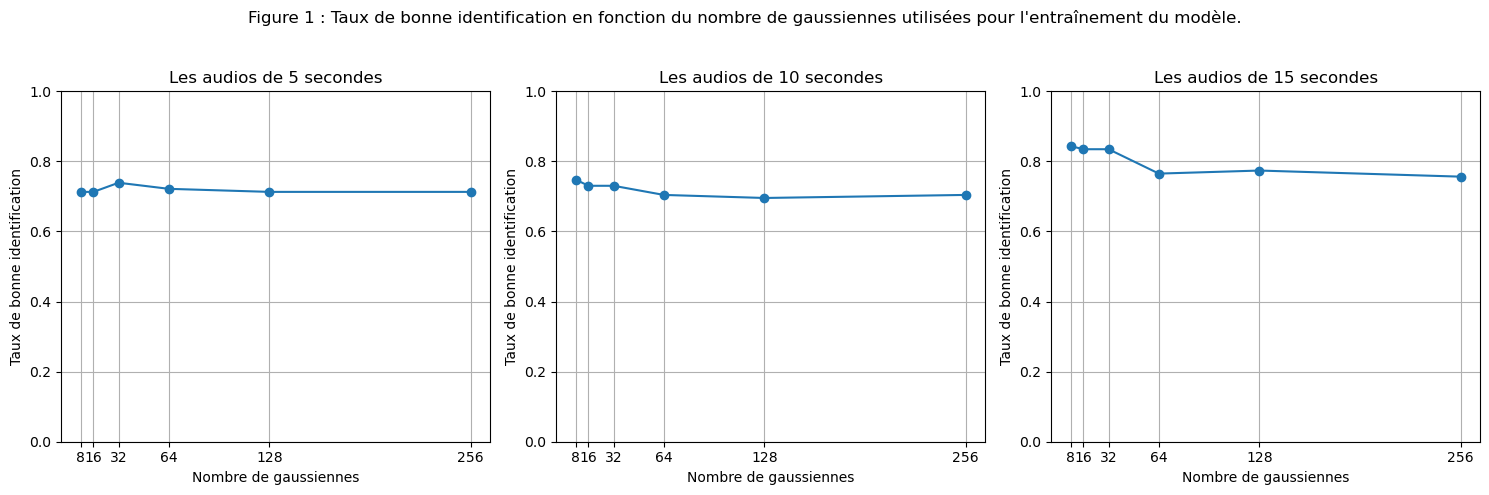

In [118]:
acc_5s = calculate_accuracy_curve("identification3_5s.xlsx")
acc_10s = calculate_accuracy_curve("identification3_10s.xlsx")
acc_15s = calculate_accuracy_curve("identification3_15s.xlsx")
plot_all_durations(acc_5s, acc_10s, acc_15s)

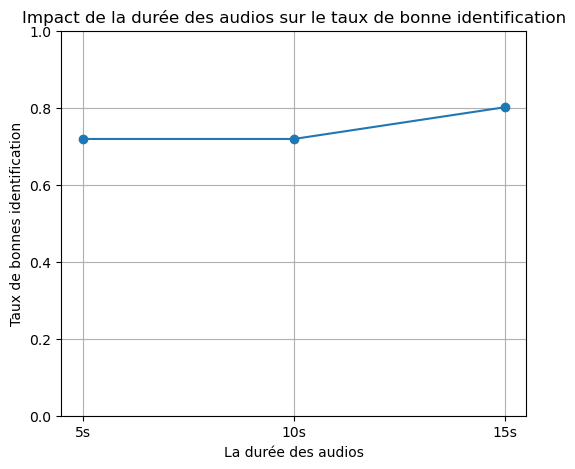

In [124]:
def calculate_overall_accuracy(file_path):
    """Retourne le taux de bonne identification global d’un fichier"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    return df['Correct'].mean()

# === Calcul pour chaque durée ===
acc_5s = calculate_overall_accuracy("identification3_5s.xlsx")
acc_10s = calculate_overall_accuracy("identification3_10s.xlsx")
acc_15s = calculate_overall_accuracy("identification3_15s.xlsx")

# === Données pour le graphique ===
durations = ['5s', '10s', '15s']
accuracies = [acc_5s, acc_10s, acc_15s]

# === Tracé ===
plt.figure(figsize=(6, 5))
plt.plot(durations, accuracies, marker='o')
plt.xlabel("La durée des audios")
plt.ylabel("Taux de bonnes identification")
plt.title("Impact de la durée des audios sur le taux de bonne identification")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


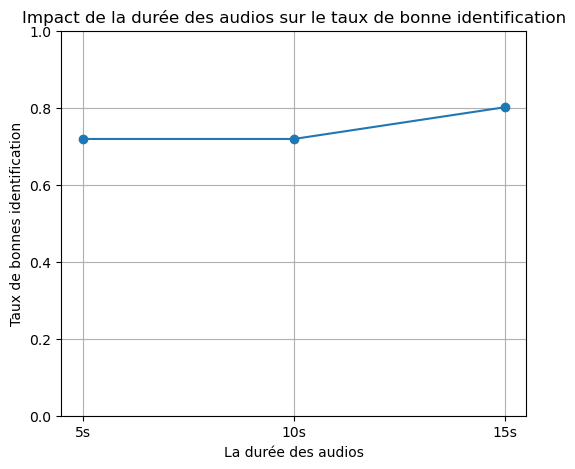

In [5]:
def calculate_overall_accuracy(file_path):
    """Retourne le taux de bonne identification global d’un fichier"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    return df['Correct'].mean()

# === Calcul pour chaque durée ===
acc_5s = calculate_overall_accuracy("identification3_5s.xlsx")
acc_10s = calculate_overall_accuracy("identification3_10s.xlsx")
acc_15s = calculate_overall_accuracy("identification3_15s.xlsx")

# === Données pour le graphique ===
durations = ['5s', '10s', '15s']
accuracies = [acc_5s, acc_10s, acc_15s]

# === Tracé ===
plt.figure(figsize=(6, 5))
plt.plot(durations, accuracies, marker='o')
plt.xlabel("La durée des audios")
plt.ylabel("Taux de bonnes identification")
plt.title("Impact de la durée des audios sur le taux de bonne identification")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


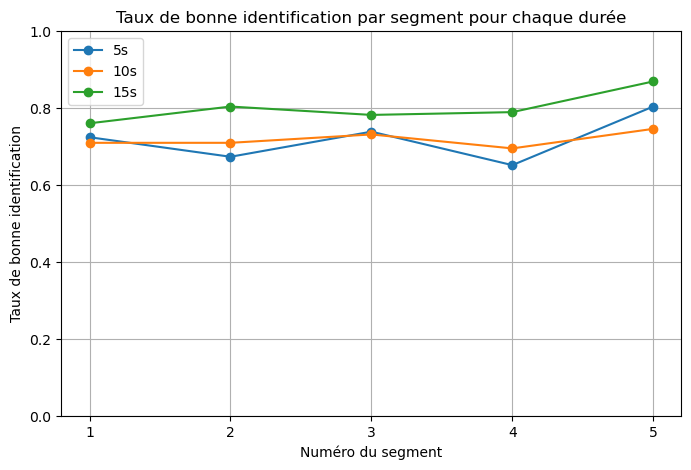

In [25]:
def calculate_accuracy_per_segment(file_path):
    """Retourne un DataFrame avec le taux de bonne identification par segment"""
    df = pd.read_excel(file_path)
    df['Correct'] = df['Locuteur'] == df['Identité prédite']
    acc_per_seg = df.groupby('Segment')['Correct'].mean().reset_index()
    acc_per_seg.columns = ['Segment', 'Taux']
    acc_per_seg['Segment'] = acc_per_seg['Segment'].str.extract(r'seg(\d)').astype(int)
    acc_per_seg = acc_per_seg.sort_values('Segment')
    return acc_per_seg

# Charger les taux par segment pour chaque durée
acc_5s = calculate_accuracy_per_segment("identification3_5s.xlsx")
acc_10s = calculate_accuracy_per_segment("identification3_10s.xlsx")
acc_15s = calculate_accuracy_per_segment("identification3_15s.xlsx")

# Tracer les courbes
plt.figure(figsize=(8, 5))
plt.plot(acc_5s['Segment'], acc_5s['Taux'], marker='o', label='5s')
plt.plot(acc_10s['Segment'], acc_10s['Taux'], marker='o', label='10s')
plt.plot(acc_15s['Segment'], acc_15s['Taux'], marker='o', label='15s')

plt.xlabel("Numéro du segment")
plt.ylabel("Taux de bonne identification")
plt.title("Taux de bonne identification par segment pour chaque durée")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


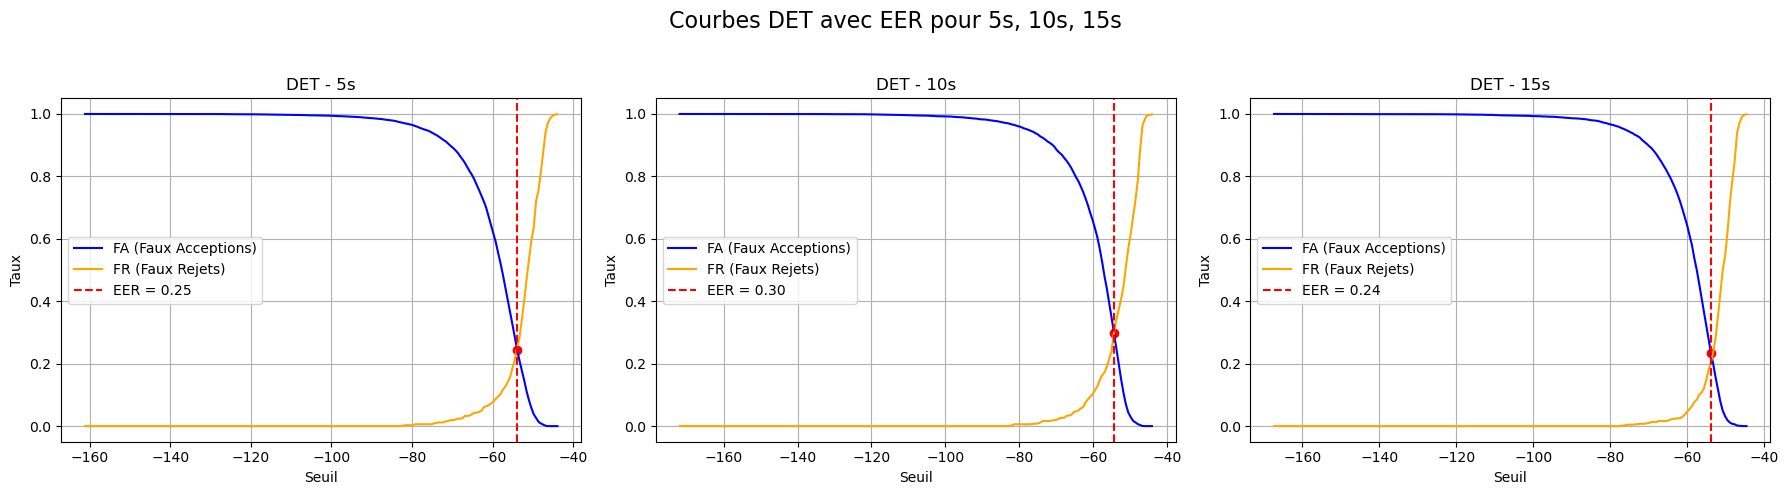

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_det_data(file_path):
    df = pd.read_excel(file_path)
    
    # Scores vrais (matching) et faux (non-matching)
    df['Correct'] = df['Locuteur'] == df['Identité testé']
    scores_vrais = df[df['Correct']]['Score'].values
    scores_faux = df[~df['Correct']]['Score'].values
    
    # Création d'une grille de seuils
    all_scores = np.concatenate([scores_vrais, scores_faux])
    seuils = np.linspace(min(all_scores), max(all_scores), 200)
    
    FPR, FNR = [], []
    for seuil in seuils:
        fa = np.mean(scores_faux >= seuil)  # Faux acceptés
        fr = np.mean(scores_vrais < seuil)  # Vrais rejetés
        FPR.append(fa)
        FNR.append(fr)

    return seuils, FPR, FNR

def plot_det(seuils, FPR, FNR, title, ax):
    diff = np.abs(np.array(FPR) - np.array(FNR))
    idx_eer = np.argmin(diff)
    eer_seuil = seuils[idx_eer]
    eer_val = FPR[idx_eer]

    ax.plot(seuils, FPR, label="FA (Faux Acceptions)", color="blue")
    ax.plot(seuils, FNR, label="FR (Faux Rejets)", color="orange")
    ax.axvline(eer_seuil, linestyle="--", color="red", label=f"EER = {eer_val:.2f}")
    ax.scatter(eer_seuil, eer_val, color="red")

    ax.set_title(title)
    ax.set_xlabel("Seuil")
    ax.set_ylabel("Taux")
    ax.grid(True)
    ax.legend()

def plot_all_dets():
    durations = ["5s", "10s", "15s"]
    files = ["test_results3_5s.xlsx", "test_results3_10s.xlsx", "test_results3_15s.xlsx"]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (d, f) in enumerate(zip(durations, files)):
        seuils, FPR, FNR = compute_det_data(f)
        plot_det(seuils, FPR, FNR, f"DET - {d}", axs[i])
    
    plt.suptitle("Courbes DET avec EER pour 5s, 10s, 15s", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 🔥 Lancer le traçage
plot_all_dets()


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_det_data(file_path, gmm_components=None):
    df = pd.read_excel(file_path)
    
    # Filtrer par nombre de Gaussiennes si spécifié
    if gmm_components is not None:
        df = df[df['GMMs'] == gmm_components]
    
    # Scores vrais (matching) et faux (non-matching)
    df['Correct'] = df['Locuteur'] == df['Identité testé']
    scores_vrais = df[df['Correct']]['Score'].values
    scores_faux = df[~df['Correct']]['Score'].values
    
    # Création d'une grille de seuils
    all_scores = np.concatenate([scores_vrais, scores_faux])
    seuils = np.linspace(min(all_scores), max(all_scores), 200)
    
    FPR, FNR = [], []
    for seuil in seuils:
        fa = np.mean(scores_faux >= seuil)  # Faux acceptés
        fr = np.mean(scores_vrais < seuil)  # Vrais rejetés
        FPR.append(fa)
        FNR.append(fr)

    return seuils, FPR, FNR

def plot_det(seuils, FPR, FNR, title, ax):
    diff = np.abs(np.array(FPR) - np.array(FNR))
    idx_eer = np.argmin(diff)
    eer_seuil = seuils[idx_eer]
    eer_val = FPR[idx_eer]

    # Formatage des valeurs pour l'affichage
    eer_seuil_text = f"{eer_seuil:.2f}"
    eer_val_text = f"{eer_val*100:.1f}%"
    
    # Courbes DET
    ax.plot(seuils, FPR, label="FA (Faux Acceptions)", color="blue")
    ax.plot(seuils, FNR, label="FR (Faux Rejets)", color="orange")
    
    # Ligne EER
    ax.axvline(eer_seuil, linestyle="--", color="red", 
               label=f"Seuil EER = {eer_seuil_text}\nEER = {eer_val_text}")
    ax.scatter(eer_seuil, eer_val, color="red")
    
    # Annotation du point EER (sans flèche)
    ax.text(eer_seuil, eer_val, 
            f'EER={eer_val_text}\nSeuil={eer_seuil_text}',
            ha='left', va='bottom', color='red',
            bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title(title, pad=20)
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Taux d'erreur")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

def plot_dets_for_gmm(gmm_components):
    durations = ["5s", "10s", "15s"]
    files = ["test_results3_5s.xlsx", "test_results3_10s.xlsx", "test_results3_15s.xlsx"]

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, (d, f) in enumerate(zip(durations, files)):
        try:
            seuils, FPR, FNR = compute_det_data(f, gmm_components)
            plot_det(seuils, FPR, FNR, f"DET Curve - {d} Samples\n{gmm_components} Gaussiennes", axs[i])
        except Exception as e:
            print(f"Erreur avec le fichier {f}: {str(e)}")
            axs[i].set_title(f"Erreur - {d}")
            axs[i].text(0.5, 0.5, "Données non disponibles", 
                       ha='center', va='center')
    
    plt.suptitle(f"Courbes DET avec Seuils Optimaux - {gmm_components} Gaussiennes", 
                fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


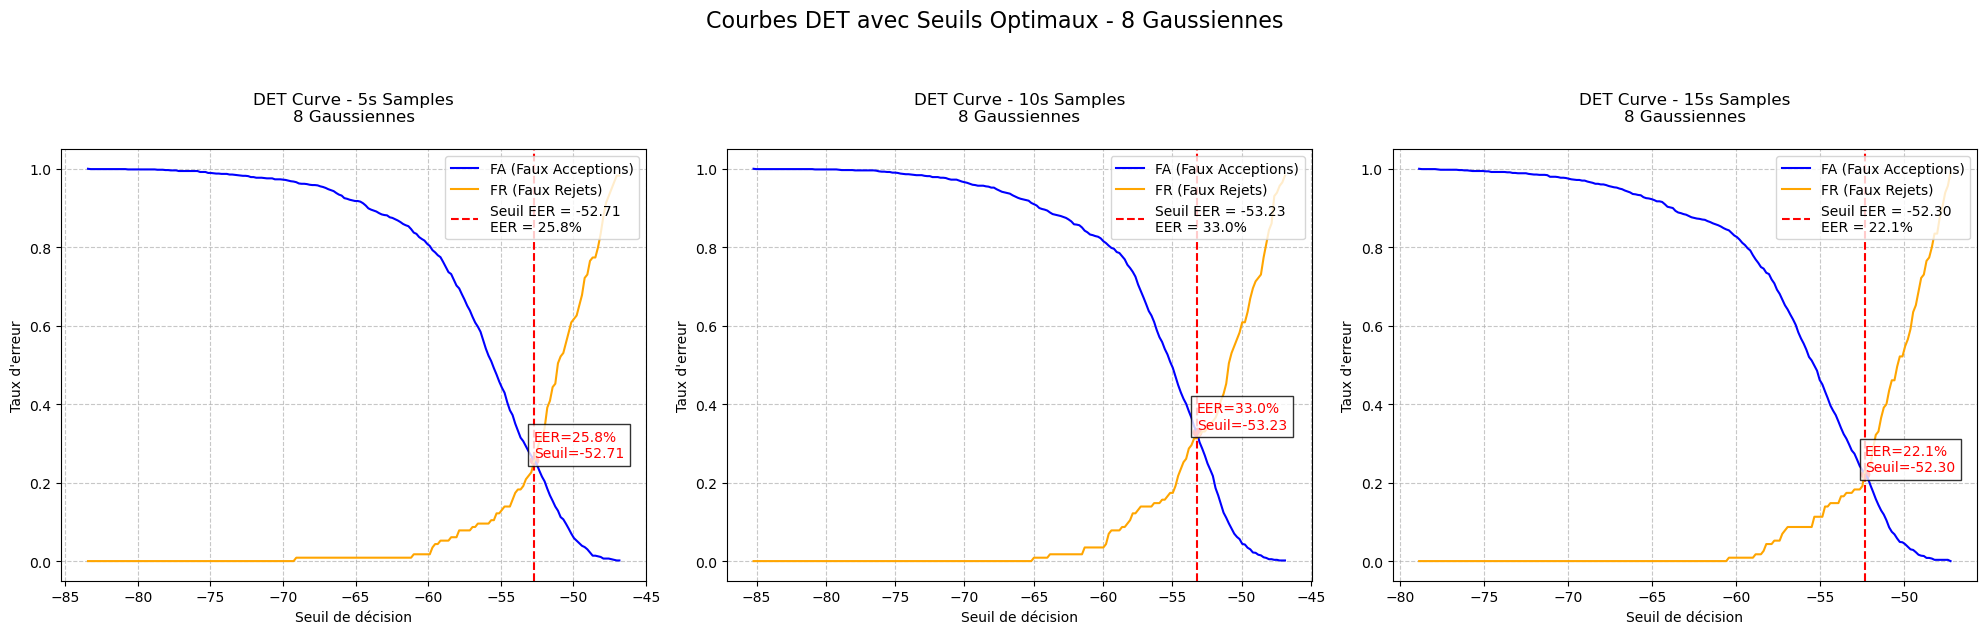

In [27]:
plot_dets_for_gmm(8)

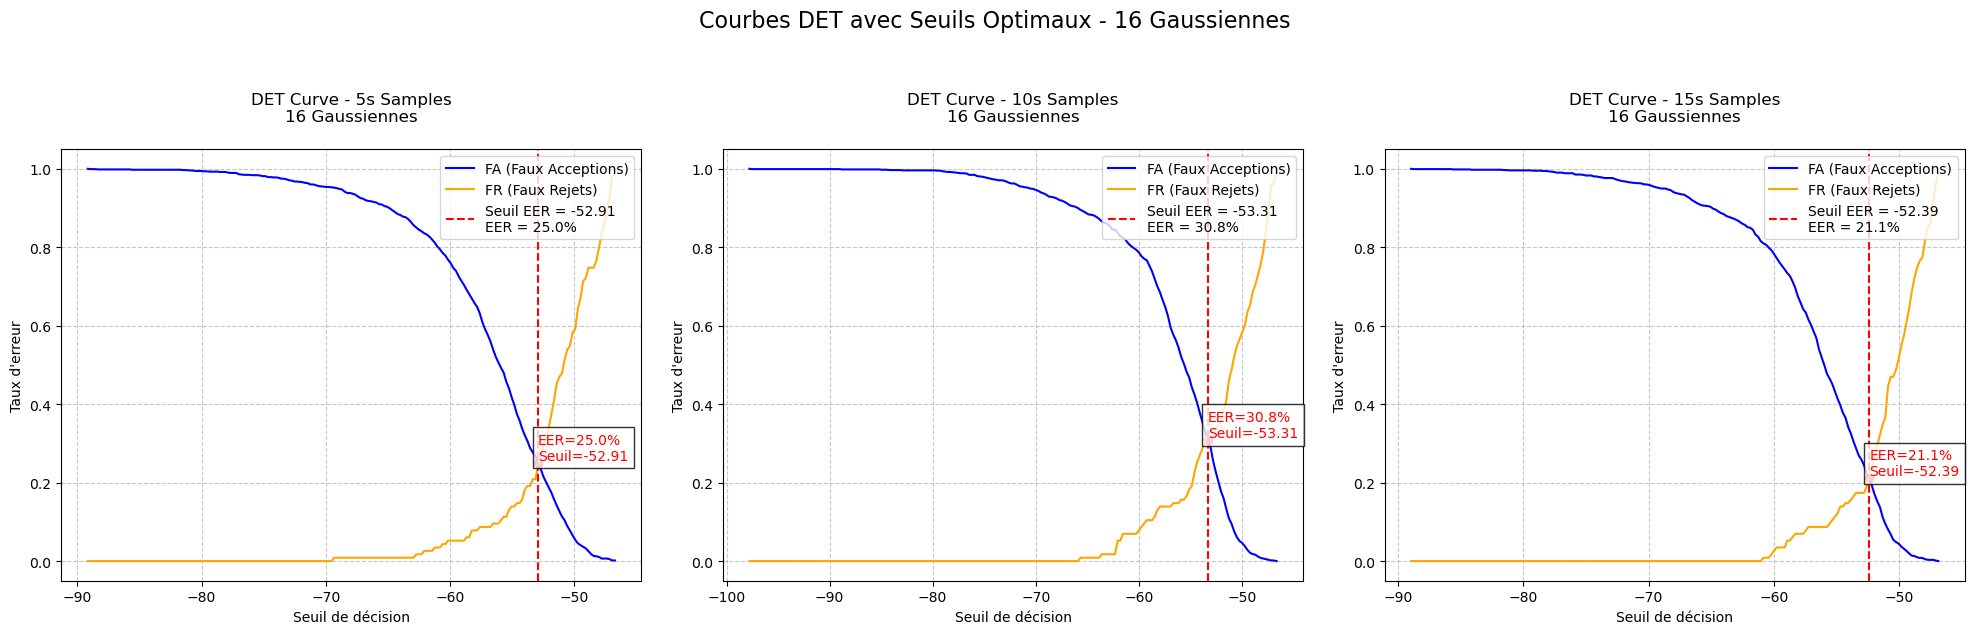

In [28]:
plot_dets_for_gmm(16)


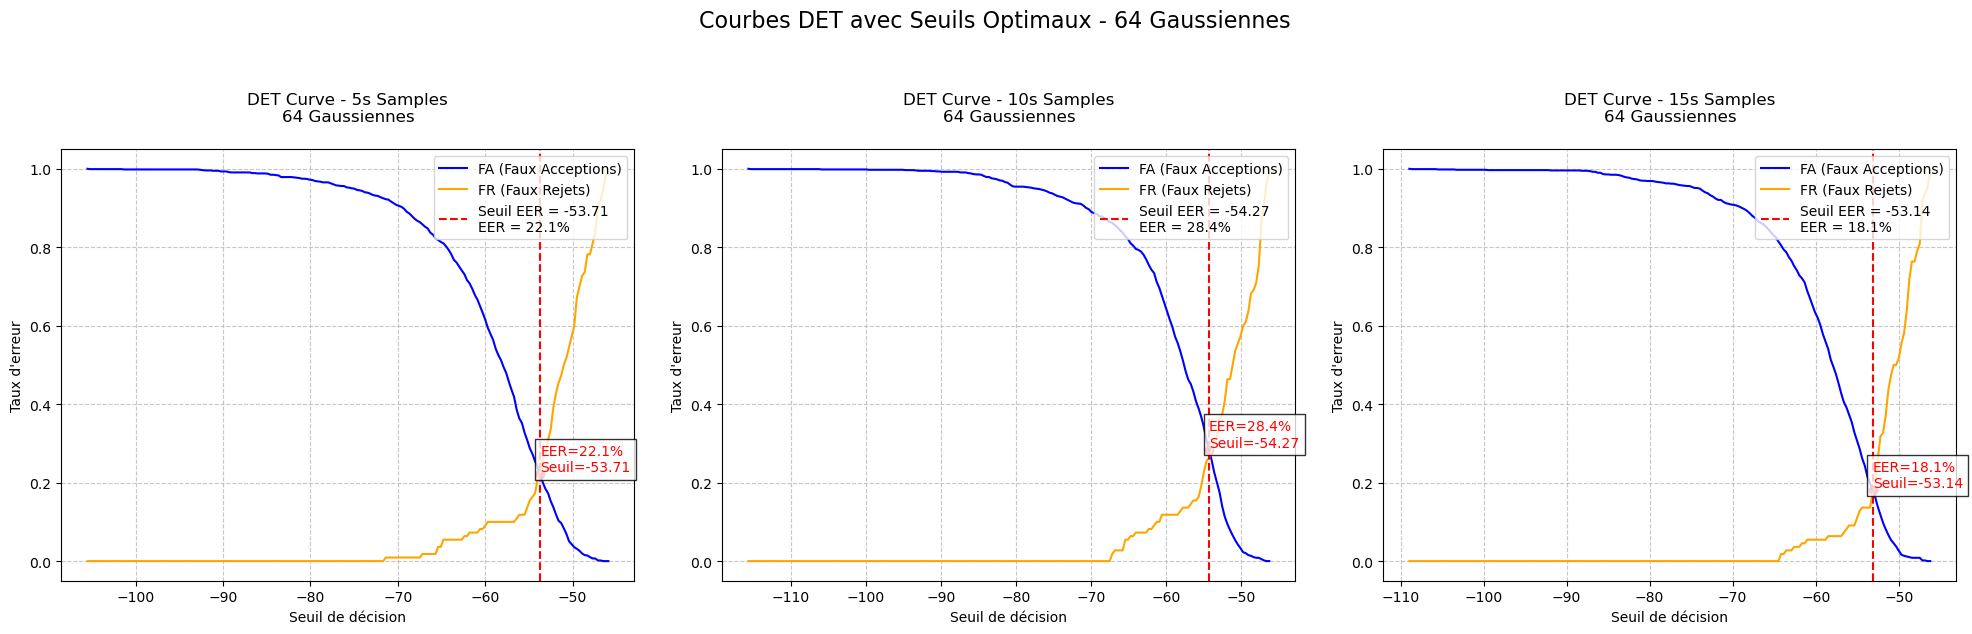

In [29]:

plot_dets_for_gmm(64)


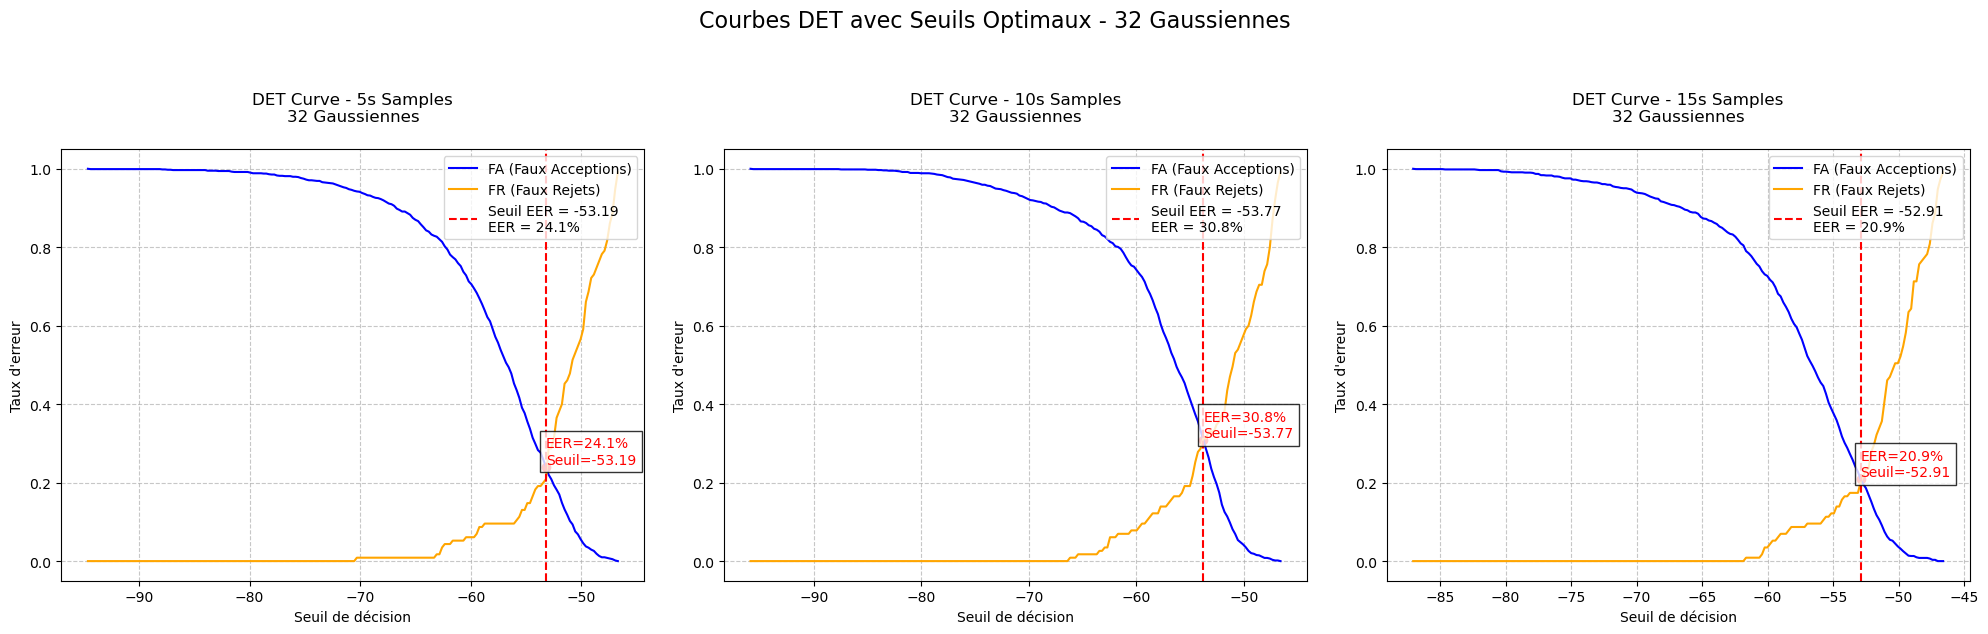

In [32]:
plot_dets_for_gmm(32)


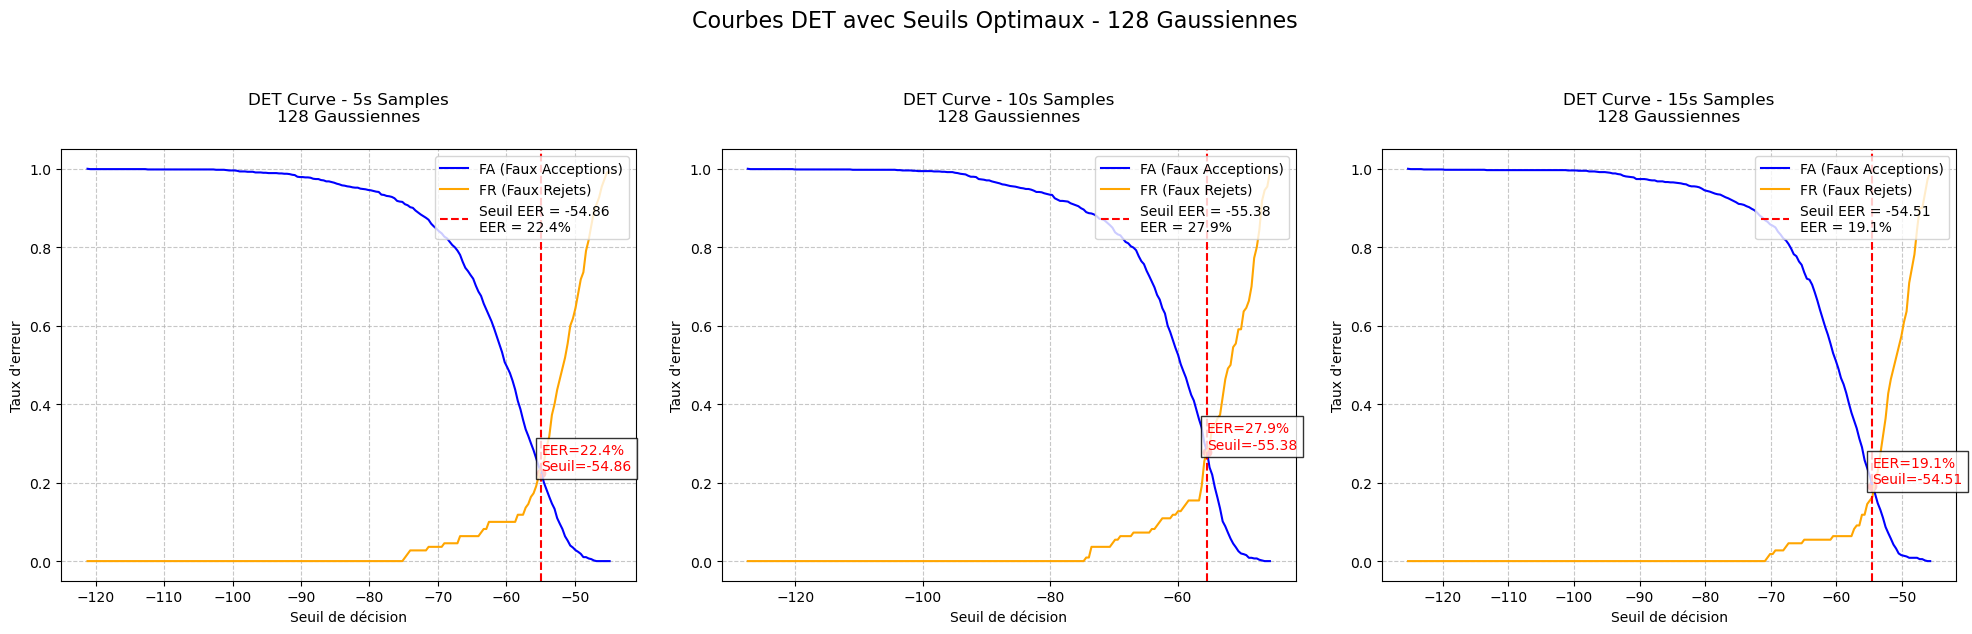

In [31]:
plot_dets_for_gmm(128)


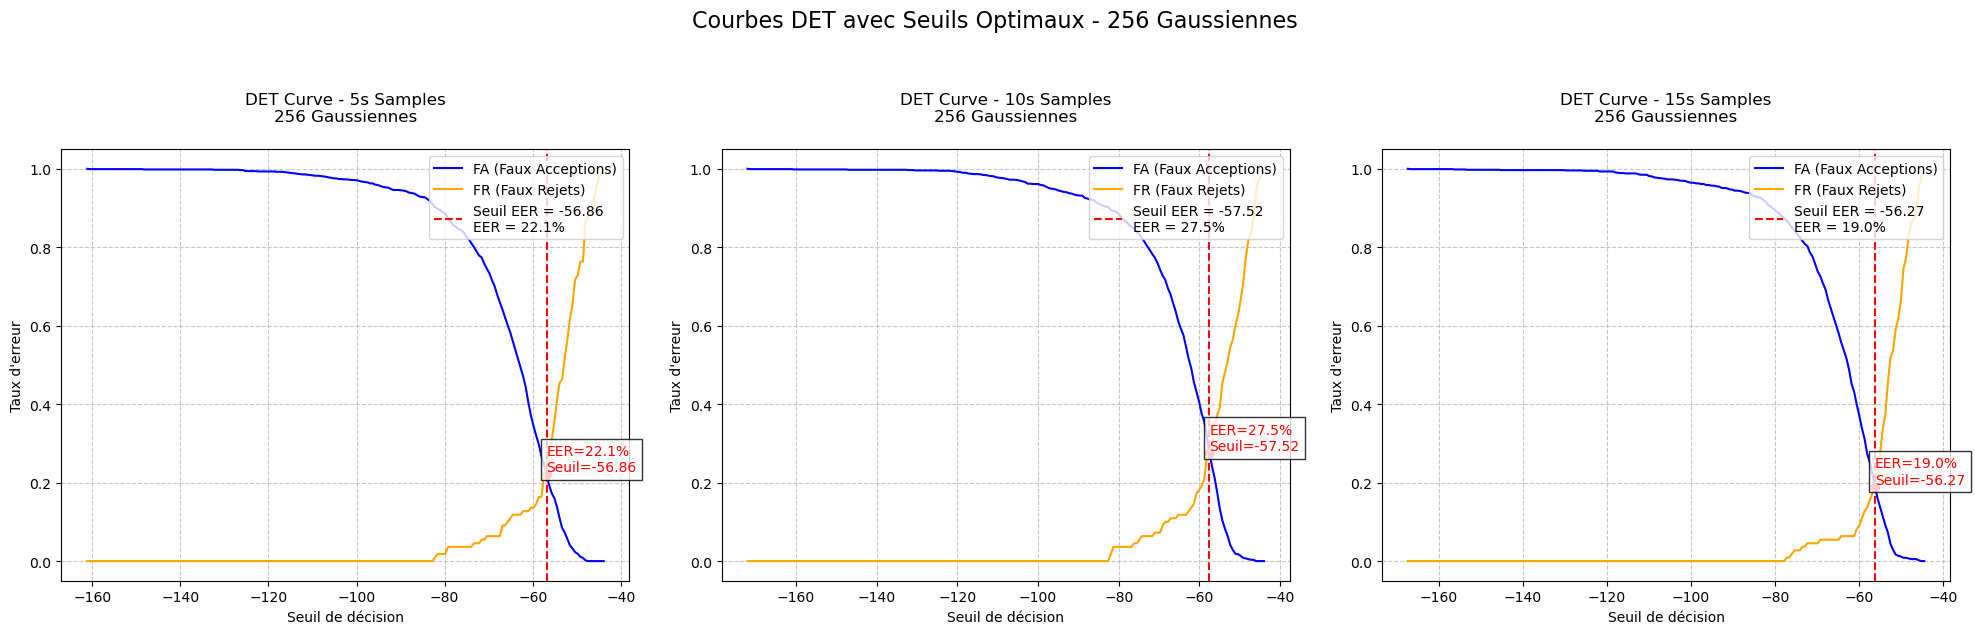

In [30]:
plot_dets_for_gmm(256)

In [24]:
def create_performance_tables():
    gmm_configs = [8, 16, 32, 64, 128, 256]
    durations = ["5s", "10s", "15s"]
    files = ["test_results3_5s.xlsx", "test_results3_10s.xlsx", "test_results3_15s.xlsx"]
    
    # Initialize empty DataFrames
    eer_df = pd.DataFrame(index=gmm_configs, columns=durations)
    seuils_df = pd.DataFrame(index=gmm_configs, columns=durations)
    
    for gmm in gmm_configs:
        for duration, file in zip(durations, files):
            try:
                seuils, FPR, FNR = compute_det_data(file, gmm)
                diff = np.abs(np.array(FPR) - np.array(FNR))
                idx_eer = np.argmin(diff)
                
                # Store values
                eer_df.loc[gmm, duration] = FPR[idx_eer]
                seuils_df.loc[gmm, duration] = seuils[idx_eer]
            except Exception as e:
                print(f"Error processing {file} for {gmm} Gaussians: {str(e)}")
                eer_df.loc[gmm, duration] = np.nan
                seuils_df.loc[gmm, duration] = np.nan
    
    # Format the tables
    eer_df_styled = (eer_df.style
                    .format("{:.3f}")
                    .set_caption("EER Values by Configuration")
                    .background_gradient(cmap='Blues'))
    
    seuils_df_styled = (seuils_df.style
                       .format("{:.2f}")
                       .set_caption("Optimal Thresholds by Configuration")
                       .background_gradient(cmap='Greens'))
    
    return eer_df, seuils_df, eer_df_styled, seuils_df_styled

# Generate and display the tables
eer_table, seuils_table, eer_styled, seuils_styled = create_performance_tables()

print("EER Table (Lower is better):")
display(eer_styled)





EER Table (Lower is better):


,5s,10s,15s
8,0.258,0.330,0.221
16,0.250,0.308,0.211
32,0.241,0.308,0.209
64,0.221,0.284,0.181
128,0.224,0.279,0.191
256,0.221,0.275,0.190


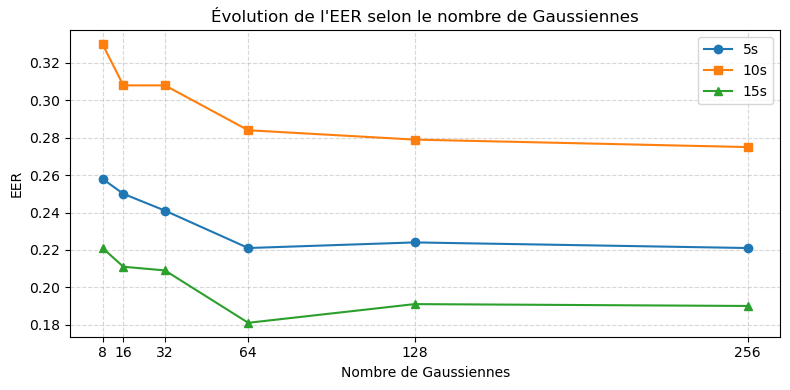

In [34]:
import matplotlib.pyplot as plt

# Nombres de gaussiennes
gaussiens = [8, 16, 32, 64, 128, 256]

# EER pour chaque durée
eer_5s = [0.258, 0.250, 0.241, 0.221, 0.224, 0.221]
eer_10s = [0.330, 0.308, 0.308, 0.284, 0.279, 0.275]
eer_15s = [0.221, 0.211, 0.209, 0.181, 0.191, 0.190]

# Tracé
plt.figure(figsize=(8, 4))  # Taille plus compacte
plt.plot(gaussiens, eer_5s, marker='o', label='5s')
plt.plot(gaussiens, eer_10s, marker='s', label='10s')
plt.plot(gaussiens, eer_15s, marker='^', label='15s')

# Mise en forme
plt.title('Évolution de l\'EER selon le nombre de Gaussiennes')
plt.xlabel('Nombre de Gaussiennes')
plt.ylabel('EER')
plt.xticks(gaussiens)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()
